<H2>Practice</H2>
    
I have done a corrected version of DCGAN. Now, I make some minor errors in this Notebook. 
1. Let fix these errors
2. Let train your corrected version on only one kind of digit

In [1]:
from keras.models import Sequential

%matplotlib inline
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Input, Conv2D, Dropout, Flatten, Dense, BatchNormalization, Reshape, UpSampling2D, Activation
from keras.optimizers import Adam, SGD
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Model
#mport time
import matplotlib.pyplot as plt
#from tqdm import tqdm
from IPython import display

In [2]:
width = 28
height = 28
channels = 1

<H2>1. Declare plots functions<H2>

In [3]:
def Plot_losses(losses, ymin, ymax):
    """Plotting G_loss and D_loss on train_set during training process"""

    plt.figure(figsize=(12,6))
    plt.title('Training losses ', fontsize=16)

    x  = losses[:,0]
    y1 = losses[:,1]
    y2 = losses[:,2]

    plt.xlim([0.0, max(x) + 1.0])
    plt.ylim([ymin,ymax])
    plt.xlim([-0.01*max(x), 1.01*max(x)])

    plt.plot(x, y1,  'b', label = 'D_loss')
    plt.plot(x, y2,  'g', label = 'G_loss')
    
    plt.legend(loc='upper right', fontsize=14)
    plt.ylabel('Losses', fontsize=14)
    plt.xlabel('Epochs', fontsize=14)
    #plt.savefig(path + data_name +"_traing_errors.pdf")
    plt.show()

In [4]:
''' Plot 16 images together. These images are either real images or fake ones'''
def plot_images(save2file=False, samples=16, step=0, images=[]):
    
    print("    ____________________ Step = %d ____________________" %step)
    plt.figure(figsize=(6, 6))
    for i in range(images.shape[0]):
        plt.subplot(4, 4, i+1)
        image = images[i, :, :, :]
        image = np.reshape(image, [height, width])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.tight_layout()

    if save2file:
        plt.savefig(str(step) + "_d.png")
        plt.close('all')
    else:
        plt.show()

<H2>2. Load MNIST data</H2>

We use only training set without label. This is because we aim to train generator to produce images that are very similar to real images. The pixel values in MNIST ranging from 0 to 255. Now we rescale these values to [-1, 1] 

In [5]:
(x_train, _), (_, _) = mnist.load_data()

# Rescale -1 to 1
x_train = (x_train.astype(np.float32) - 127.5) / 127.5
x_train = np.expand_dims(x_train, axis=3)

print(x_train.shape)

11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1)


Show digits in gray-scale

(16, 28, 28, 1)
    ____________________ Step = 0 ____________________


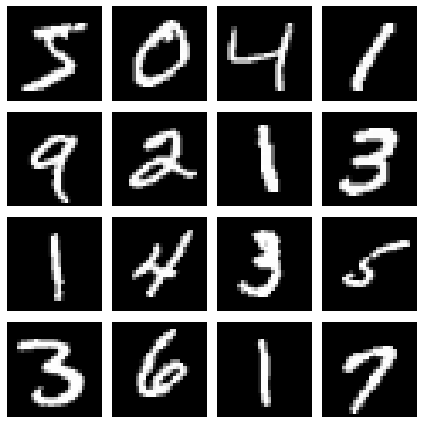

In [6]:
samples = np.reshape(x_train[0:16], (-1,28,28,1))
print(np.shape(samples))
plot_images(save2file=False, step=0, images = samples)

In [7]:
shp = x_train.shape[1:]
inidim = 100
print(shp)
# Optim
dropout_rate = 0.3
opt  = Adam(lr=2e-4,beta_1=0.5)
dopt = Adam(lr=2e-4,beta_1=0.5)

(28, 28, 1)


<H2>3. Generator</H2>

In [8]:
""" Declare a generator. 
    + Its input is a 100-feature vector of random values.
    + its output is a fake image with pixel values in [-1, 1]. """
def generator():
    model = Sequential()
    model.add(Dense(7*7*128, kernel_initializer='glorot_normal',input_shape=(inidim,)))
    model.add(LeakyReLU(0.2))
    model.add(Reshape( [7, 7, 128]))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(64, (5, 5), padding='same', kernel_initializer='glorot_uniform'))
    model.add(LeakyReLU(0.2))
    model.add(UpSampling2D(size=(2, 2)))
    model.add(Conv2D(1, (5, 5), padding='same', kernel_initializer='glorot_uniform'))
    model.add(Activation('tanh'))
    return model
print("_____________________ Generator Architecture_____________________")
G = generator()
G.compile(loss='binary_crossentropy', optimizer=opt)
G.summary()

_____________________ Generator Architecture_____________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6272)              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0         
________________________________________________________

<H2>4. Discriminator</H2>

In [9]:
""" Declare discriminator 
    + Its input is image (in a form of a vector 28x28)
    + Its ouput is the probability of image type (real-image or fake image)
    the values in the range of [0, 1] """

def discriminator():
    model = Sequential()
    #model.add(Dense(7*7*128, kernel_initializer='glorot_normal',input_shape=(inidim,)))
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding= 'same',input_shape=shp))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(dropout_rate))
    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding = 'same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(dropout_rate))
    model.add(Flatten())
    model.add(Dense(2,activation='sigmoid'))
    return model
print("___________________ Discriminator Architecture___________________")
D = discriminator()
D.compile(loss='binary_crossentropy', optimizer=dopt)
D.summary()

___________________ Discriminator Architecture___________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
______________________________________________________

<h2>5. Generative model</h2>

We stack generator and discriminator to form a generative mode (gen_model)

### Note: the Train Loop
- Train the discriminator to become a a classifier of real and fake images
- Train generator in order to produce fake images from noise

- Therefore, we train the discriminator and the generator in turn in a loop as follows:

    #### Step 1) Set the discriminator trainable
    #### Step 2) Train the discriminator with the real images and fake images.
    #### Step 3) Set the discriminator non-trainable
    #### Step 4) Train the generator as part of the GAN. Feed latent samples into the generator to produce fake images and use the discriminator to classify the images.

The loop should ideally continue until they are both trained well and can not be improved any further.

In [10]:
"""Thus, we set trainable = False to prevent weight updating in Discriminator"""
def dcgan_model(generator, discriminator):
    #We do not train discriminator this phase 
    discriminator.trainable = False
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [11]:
optimizer = Adam(lr=0.0002, beta_1=0.5, decay=8e-8)

G = generator()
G.compile(loss='binary_crossentropy', optimizer=optimizer)

D = discriminator()
D.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

GAN = dcgan_model(G,D)
GAN.compile(loss='binary_crossentropy', optimizer=optimizer)
GAN.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 28, 28, 1)         839937    
_________________________________________________________________
sequential_3 (Sequential)    (None, 2)                 219138    
Total params: 1,059,075
Trainable params: 839,937
Non-trainable params: 219,138
_________________________________________________________________


In [13]:
epochs     = 200
batch_size = 32
plt_frq    = 10
samples    = []
losses     = []
    #for e in tqdm(range(nb_epoch)):  
for e in range(epochs):

    # Make generative images
    image_batch = x_train[np.random.choice(x_train.shape[0], size=batch_size),:,:,:]    
    noise_gen = np.random.normal(0,1,size=[batch_size,inidim])
    generated_images = G.predict(noise_gen)

    # Train discriminator on generated images
    X = np.concatenate((image_batch, generated_images))
    y = np.zeros([2*batch_size,2])
    y[0:batch_size,1] = 1
    y[batch_size:,0] = 1
    
    D.trainable = True
    d_loss  = D.train_on_batch(X,y)

    
    # train Generator-Discriminator stack on input noise to non-generated output class
    D.trainable = False
    
    noise_tr = np.random.normal(0,1,size=[2*batch_size,inidim])
    y2 = np.ones([2*batch_size,2])
    y2[:,1] = 1
    g_loss = GAN.train_on_batch(noise_tr, y2 )


    if e%plt_frq==0:        
        noise = np.random.normal(0, 1, (16, 100))
        gen_images = G.predict(noise)
        samples.append(gen_images)
        
        a = [e, d_loss[0], g_loss]
        losses = np.append(losses, a)
        
        print ('epoch: %3.0d, Discriminator :: d_loss: %0.4f], [ Generator :: loss: %0.4f]' % (e, d_loss[0], g_loss))

epoch:   0, Discriminator :: d_loss: 0.7116], [ Generator :: loss: 0.6949]
epoch:  10, Discriminator :: d_loss: 0.3138], [ Generator :: loss: 0.6916]
epoch:  20, Discriminator :: d_loss: 0.4358], [ Generator :: loss: 0.7360]
epoch:  30, Discriminator :: d_loss: 0.1154], [ Generator :: loss: 1.2395]
epoch:  40, Discriminator :: d_loss: 0.4729], [ Generator :: loss: 0.7382]
epoch:  50, Discriminator :: d_loss: 0.3414], [ Generator :: loss: 0.6811]
epoch:  60, Discriminator :: d_loss: 0.3441], [ Generator :: loss: 0.6759]
epoch:  70, Discriminator :: d_loss: 0.4960], [ Generator :: loss: 0.7868]
epoch:  80, Discriminator :: d_loss: 0.4270], [ Generator :: loss: 0.7058]
epoch:  90, Discriminator :: d_loss: 0.4021], [ Generator :: loss: 0.7323]
epoch: 100, Discriminator :: d_loss: 0.3983], [ Generator :: loss: 0.7166]
epoch: 110, Discriminator :: d_loss: 0.4502], [ Generator :: loss: 0.6865]
epoch: 120, Discriminator :: d_loss: 0.4382], [ Generator :: loss: 0.7135]
epoch: 130, Discriminator

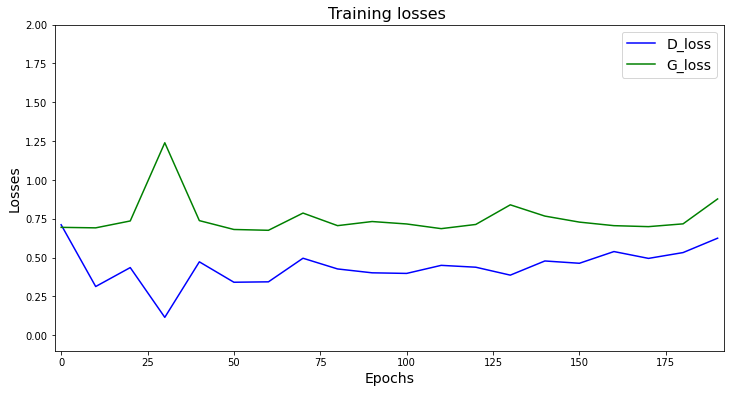

DCGAN is difficult to converge because the training processes of Generator and Discriminator are conflict each others. 



In [14]:
losses = np.reshape(losses, (-1,3))
Plot_losses(losses, -0.1, 2)
print("DCGAN is difficult to converge because the training processes of Generator and Discriminator are conflict each others. \n")

    ____________________ Step = 0 ____________________


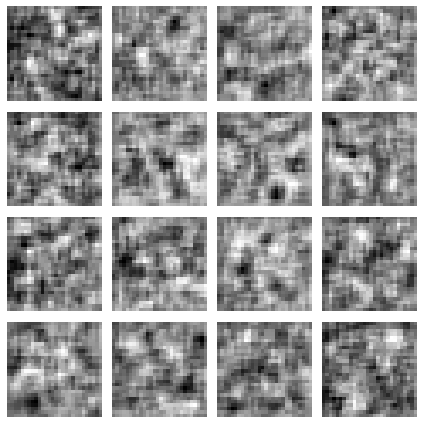



    ____________________ Step = 10 ____________________


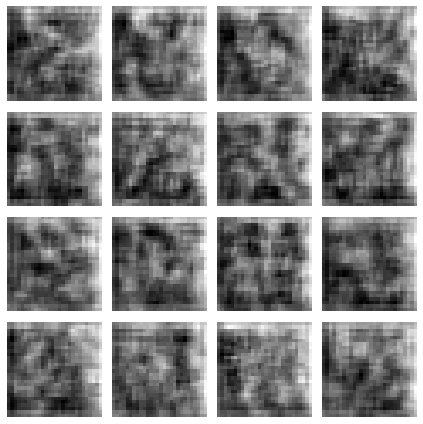



    ____________________ Step = 20 ____________________


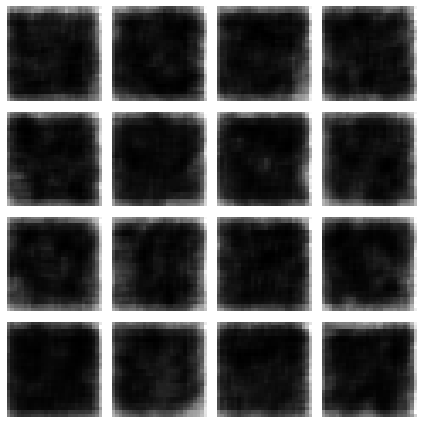



    ____________________ Step = 30 ____________________


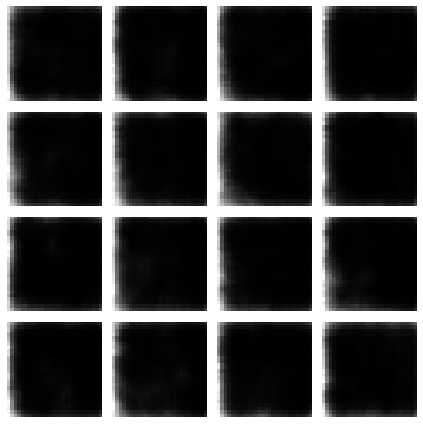



    ____________________ Step = 40 ____________________


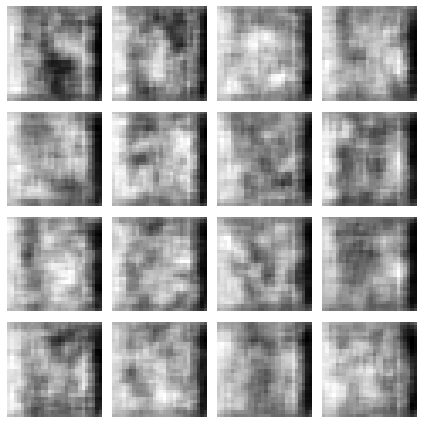



    ____________________ Step = 50 ____________________


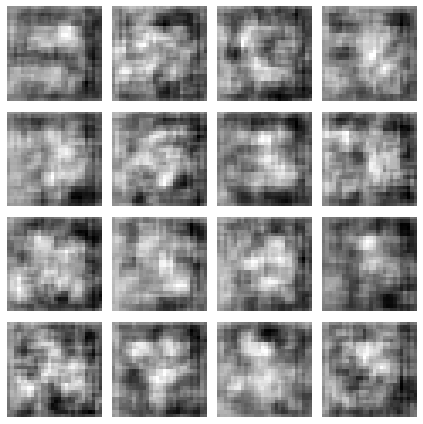



    ____________________ Step = 60 ____________________


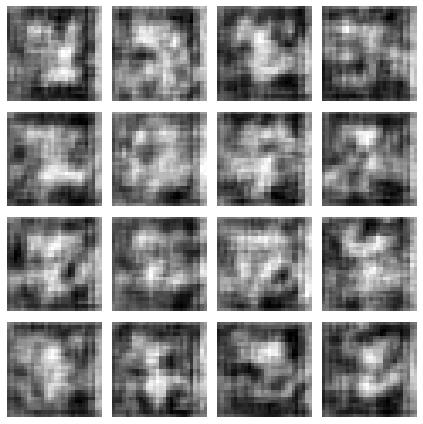



    ____________________ Step = 70 ____________________


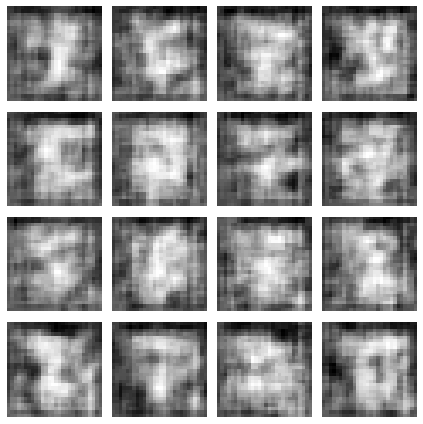



    ____________________ Step = 80 ____________________


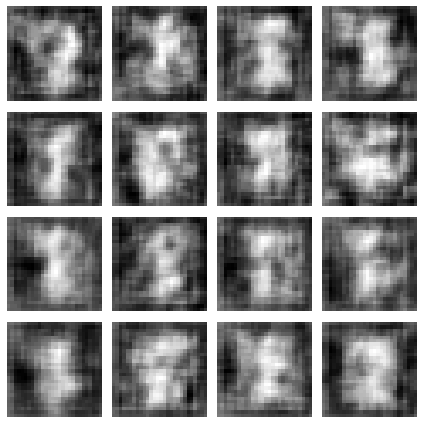



    ____________________ Step = 90 ____________________


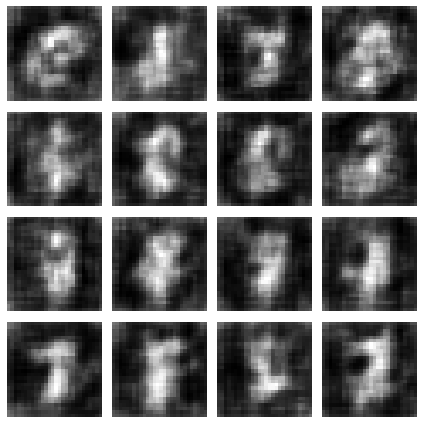



    ____________________ Step = 100 ____________________


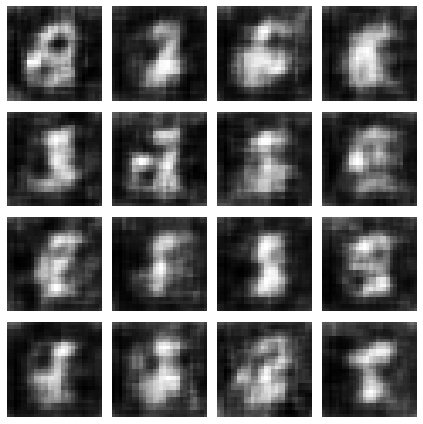



    ____________________ Step = 110 ____________________


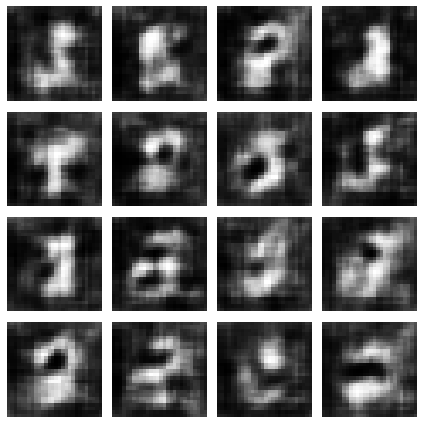



    ____________________ Step = 120 ____________________


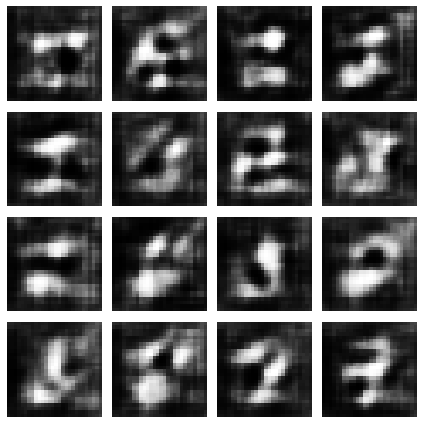



    ____________________ Step = 130 ____________________


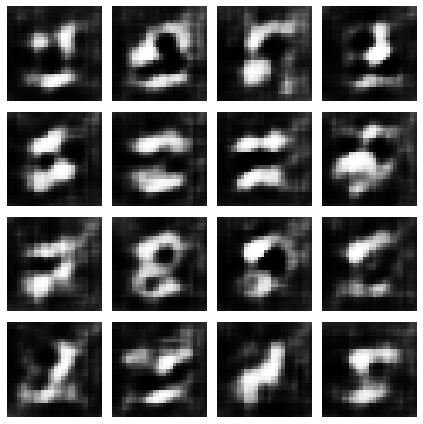



    ____________________ Step = 140 ____________________


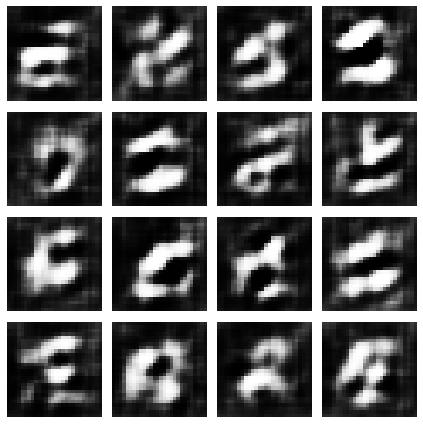



    ____________________ Step = 150 ____________________


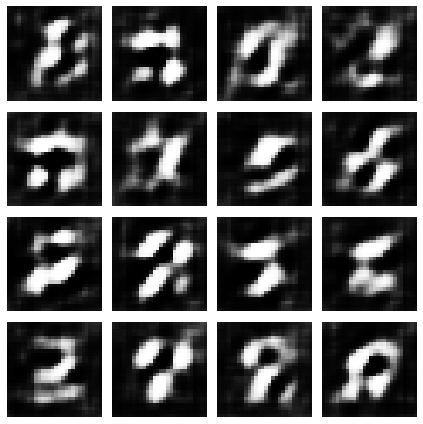



    ____________________ Step = 160 ____________________


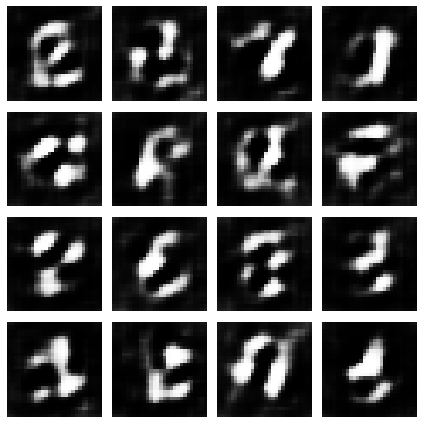



    ____________________ Step = 170 ____________________


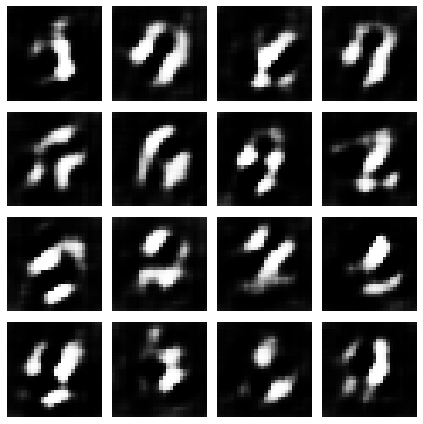



    ____________________ Step = 180 ____________________


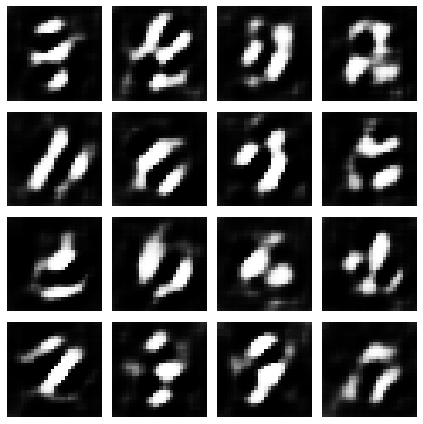



    ____________________ Step = 190 ____________________


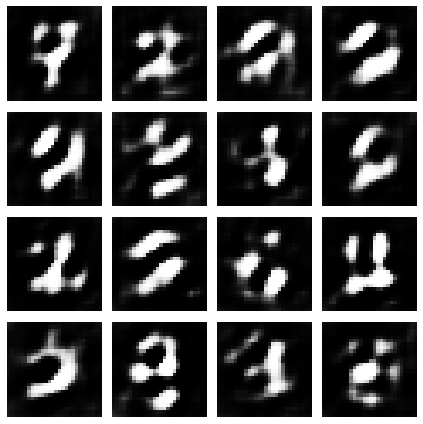

In [15]:
i = 0
for images in samples:
    step = i*plt_frq
    plot_images(save2file=False, step=step, images = images)
    print("\n")
    i = i + 1